In [1]:
import numpy as np
import pandas as pd
from lets_plot import *

In [4]:
from numba import jit
from copy import copy
from scipy import ndimage

In [5]:
@jit
def log_threshold(z):
    return np.log(np.log(z))/np.log(2)

In [6]:
@jit
def mandelbrot(c, threshold=2, num_iter=30, anti_aliasing=True):
    z = c
    for i in range(num_iter):
        if np.abs(z) > threshold:
            return i - (log_threshold(np.abs(z)) - log_threshold(threshold))*anti_aliasing
        z = z*z + c
    return 0

In [7]:
@jit
def mandelbrot_set(x_min, x_max, y_min, y_max, width=270, height=270, threshold=2**40, num_iter=30, power=0.2, anti_aliasing=True):
    xs = np.linspace(x_min, x_max, width)
    ys = np.linspace(y_min, y_max, height)
    img = np.array([mandelbrot(complex(x, y), threshold, num_iter, anti_aliasing)**power for y in ys for x in xs])
    return img

In [8]:
@jit
def partial(Z, axis=0, dx=1.):
    if axis==0:
        return (Z[:-2,1:-1] - Z[2:,1:-1])/dx
    elif axis==1:
        return (Z[1:-1,:-2] - Z[1:-1,2:])/dx

In [9]:
@jit
def laplacian(Z, dx=1.):
    return (                 Z[:-2,1:-1] +
        Z[1:-1,:-2] - 4*Z[1:-1,1:-1] + Z[1:-1,2:] +
        Z[2:,1:-1] )/dx**2

In [10]:
def get_boundaries(center, span, zoom):
    return center - span/2.**zoom, center + span/2.**zoom 

In [11]:
def plot_colored_image(image, rgb, shape, x_size, y_size, title):
    width, height = shape
    colored_image = np.zeros((width, height, 3))
    red, green, blue = rgb
    colored_image[:,:, 0] = image * red
    colored_image[:,:, 1] = image * green
    colored_image[:,:, 2] = image * blue
    plot = ggplot() + geom_image(colored_image) + ggsize(x_size, y_size) + theme(legend_position='none', axis_ticks='blank', axis_line='blank', axis_title='blank', axis_text='blank') + ggtitle(title)
    return plot

In [12]:
def plot_mandelbrot_set(zoom=1, center=(-0.5, 0.0), rgb=(0.5, 0.2, 0.9), delta_x=1, delta_y=1, width=500, height=500, threshold=2**40, num_iter_exp=5, power=0.19, x_size=500, y_size=500, dx=1., anti_aliasing=True):
    center_x, center_y = center
    x_min, x_max = get_boundaries(center_x, delta_x, zoom) 
    y_min, y_max = get_boundaries(center_y, delta_y, zoom)
    num_iter = 2**num_iter_exp
    image = mandelbrot_set(x_min, x_max, y_min, y_max, width, height, threshold, num_iter, power, anti_aliasing) 
    image = image.reshape(width, height)

    bunch = GGBunch()
    plot = plot_colored_image(image, rgb, image.shape, x_size, y_size, f'Zoom: {zoom}')
    bunch.add_plot(plot, 0, 0)

    diff_image = laplacian(image, dx=dx)
    diff_image = .2*diff_image
    diff_image_shape = (width - 2*int(dx), height - 2*int(dx))

    plot = plot_colored_image(diff_image, rgb, diff_image_shape, x_size, y_size, f'Center: {center}')
    bunch.add_plot(plot, x_size, 0)
    bunch.show()


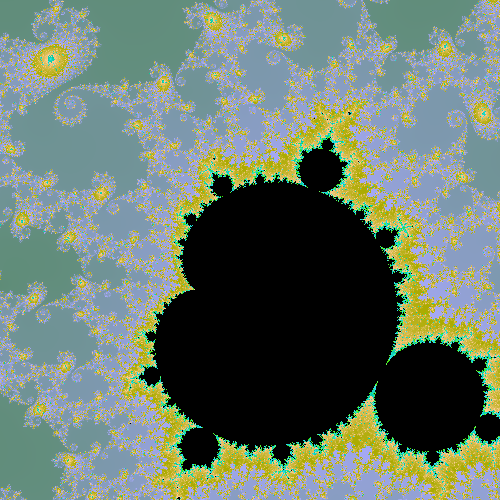
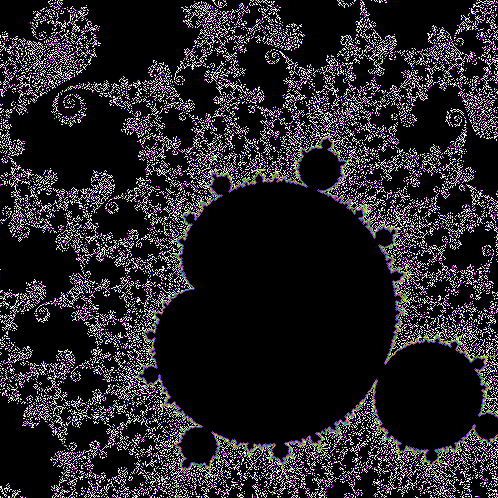

In [13]:
plot_mandelbrot_set(zoom=16, center=(-0.7487475, 0.0650725), num_iter_exp=12)

### Mandelbulb
There is no strict analogy for complex numbers in 3D space, so there are a number of ways to determine 3D fractals. Some of them use quaternions.

Consider 3D polar coordinates:
$$
\left\{
\begin{array}{l}
r = \sqrt{x^2+y^2+z^2},\\
\theta = \arctan\left(\frac{\sqrt{x^2+y^2}}{z}\right),\\
\phi=\arctan\left(\frac{y}{x}\right),
\end{array}
\right.
$$
Going back to Descartes coordinates we get:
$$\left\{
\begin{array}{l}
x = r\sin\theta\cos\phi\\
y = r\sin\theta\sin\phi\\
z = r\cos\theta
\end{array}
\right.$$
Given $v = (x,y,z)$, we can define the $n$-th power of this triple:
$$(x,y,z)^n=r^n\left(\sin n\theta\cos n\phi, \sin n\theta \sin n \phi, \cos n\theta\right)$$
Now we can define the recurrent formula for the 3D Mandelbrot set (called a Mandelbulb) as $\displaystyle v_{n+1}=v_n^p + c$, where $c=(x,y,z)$. The typical choice for the power $p$ is 8. 


In [14]:
def get_plane_points(Q, center, span, zoom, width, height):
    x_min, x_max = get_boundaries(center[0], span[0], zoom) 
    y_min, y_max = get_boundaries(center[1], span[1], zoom)
    a, b , c = Q
    x = np.linspace(x_min, x_max, width)
    y = np.linspace(y_min, y_max, height)
    x, y = np.meshgrid(x, y)
    x, y = x.reshape(-1), y.reshape(-1)
    if np.abs(c) > 1e-4:
        z = -(a*x + b*y)/c
        P = np.vstack((x, y, z)).T
    elif np.abs(a) > 1e-4:
        z = -(c*x + b*y)/a
        P = np.vstack((z, y, x)).T
    elif np.abs(b) > 1e-4:
        z = -(a*x + c*y)/b
        P = np.vstack((x, z, y)).T
    return P

In [15]:
def get_directions(P, Q):
    v = np.array(P - Q)
    v = v/np.linalg.norm(v, axis=1)[:, np.newaxis]
    return v

In [16]:
@jit
def DistanceEstimator(positions, iterations, degree=8, bailout=1000):
    m = positions.shape[0]
    x, y, z = np.zeros(m), np.zeros(m), np.zeros(m)
    x0, y0, z0 = positions[:, 0], positions[:, 1], positions[:, 2]
    dr = np.zeros(m) + 1
    r = np.zeros(m)
    theta = np.zeros(m)
    phi = np.zeros(m)
    zr = np.zeros(m)
    for _ in range(iterations):
        r = np.sqrt(x*x + y*y + z*z)
        idx1 = r < bailout
        dr[idx1] = np.power(r[idx1], degree - 1) * degree * dr[idx1] + 1.0

        theta[idx1] = np.arctan2(np.sqrt(x[idx1]*x[idx1] + y[idx1]*y[idx1]), z[idx1])
        phi[idx1] = np.arctan2(y[idx1], x[idx1])

        zr[idx1] = r[idx1] ** degree
        theta[idx1] = theta[idx1] * degree
        phi[idx1] = phi[idx1] * degree

        x[idx1] = zr[idx1] * np.sin(theta[idx1]) * np.cos(phi[idx1]) + x0[idx1]
        y[idx1] = zr[idx1] * np.sin(theta[idx1]) * np.sin(phi[idx1]) + y0[idx1]
        z[idx1] = zr[idx1] * np.cos(theta[idx1]) + z0[idx1]

    return 0.5 * np.log(r) * r / dr

In [17]:
def trace(start, directions, max_steps, min_distance, iterations, degree, bailout, power):
    total_distance = np.zeros(directions.shape[0])
    keep_iterations = np.ones_like(total_distance)
    steps = np.zeros_like(total_distance)
    for _ in range(max_steps):
        positions = start[np.newaxis, :] + total_distance[:, np.newaxis] * directions
        distance = DistanceEstimator(positions, iterations, degree, bailout)
        keep_iterations[distance < min_distance] = 0
        total_distance += distance * keep_iterations
        steps += keep_iterations
    return 1 - (steps/max_steps)**power

In [18]:
def plot_mandelbulb(degree=8, observer_position=np.array([1., 1., 3.]), max_steps=32, iterations=32, bailout=32000, min_distance=5e-3, zoom=0, power=0.2, width=500, height=500, x_size=500, y_size=500, span=[1.2, 1.2], center=[0, 0]):
    plane_points = get_plane_points(observer_position, center=center, span=span, zoom=zoom, width=width, height=height)
    directions = get_directions(plane_points, observer_position)
    image = trace(observer_position, directions, max_steps, min_distance, iterations, degree, bailout, power)
    image = image.reshape(width, height)
    p = ggplot() \
        + geom_image(image) + ggsize(x_size, y_size) \
        + theme(legend_position='none', axis_ticks='blank', axis_line='blank', axis_title='blank', axis_text='blank')
    return p

In [19]:
def plot_mandelbulb(degree=8, observer_position=np.array([1., 1., 3.]), max_steps=32, iterations=32, bailout=32000, min_distance=5e-3, zoom=0, power=0.2, width=500, height=500, x_size=500, y_size=500, span=[1.2, 1.2], center=[0, 0]):
    plane_points = get_plane_points(observer_position, center=center, span=span, zoom=zoom, width=width, height=height)
    directions = get_directions(plane_points, observer_position)
    image = trace(observer_position, directions, max_steps, min_distance, iterations, degree, bailout, power)
    image = image.reshape(width, height)

    p = ggplot() \
        + geom_image(image) + ggsize(x_size, y_size) \
        + theme(legend_position='none', axis_ticks='blank', axis_line='blank', axis_title='blank', axis_text='blank')

    return p

In [20]:
observer_position = np.array([1., 2., 3.])
degree = 8 # defines the form of the bulb


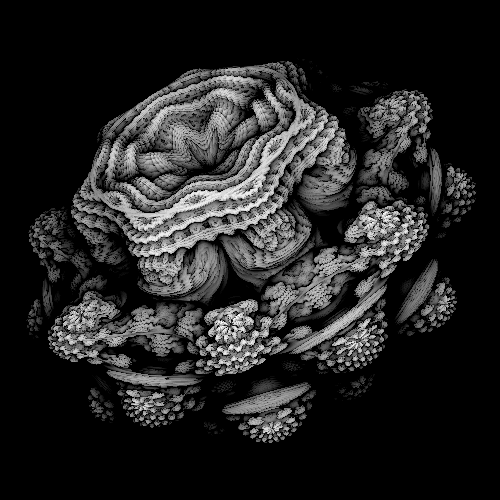

In [21]:
plot_mandelbulb(zoom=0, degree=degree, observer_position=observer_position, bailout=2**20, min_distance=5e-4)


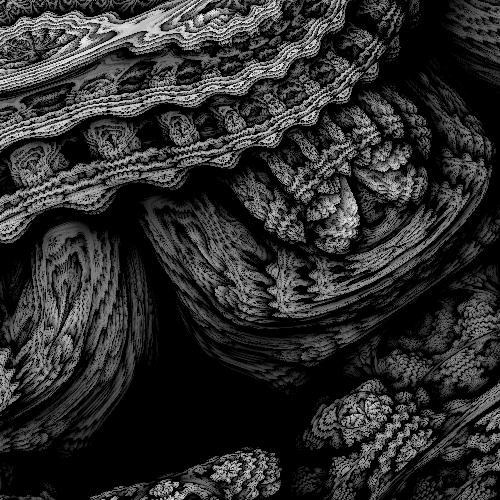

In [22]:
plot_mandelbulb(zoom=2, degree=degree, observer_position=observer_position, bailout=2**40, min_distance=5e-5)


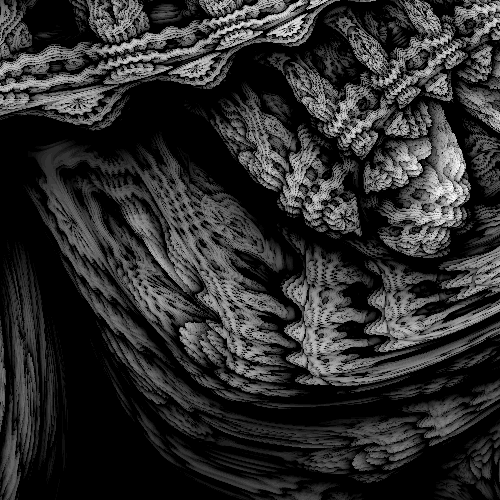

In [23]:
plot_mandelbulb(zoom=3, degree=degree, observer_position=observer_position, bailout=2**40, min_distance=5e-5)


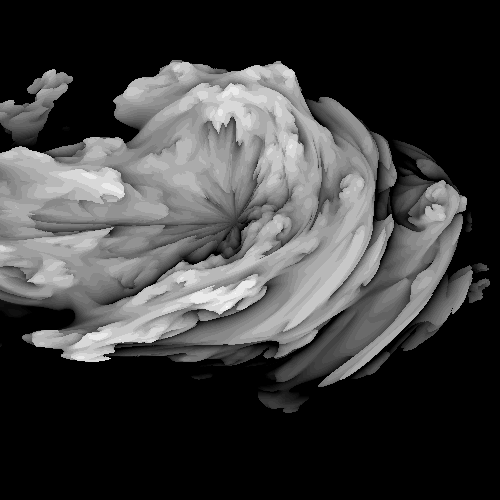

In [24]:
plot_mandelbulb(zoom=0, degree=2, observer_position=observer_position, bailout=2**40, min_distance=5e-3)


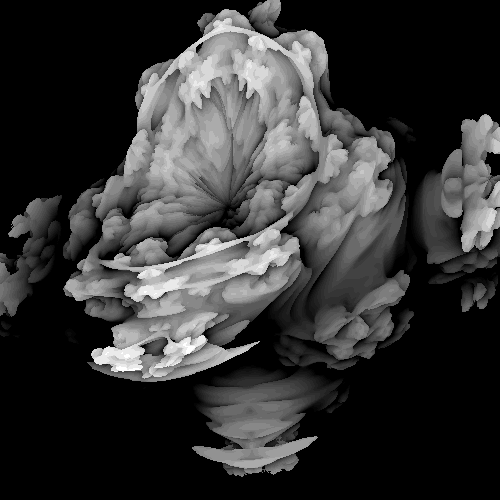

In [25]:
plot_mandelbulb(zoom=0, degree=3, observer_position=observer_position, bailout=2**40, min_distance=5e-3)


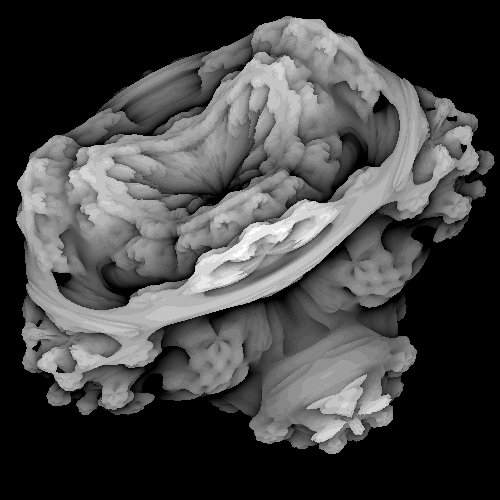

In [26]:
plot_mandelbulb(zoom=0, degree=4, observer_position=observer_position, bailout=2**40, min_distance=5e-3)


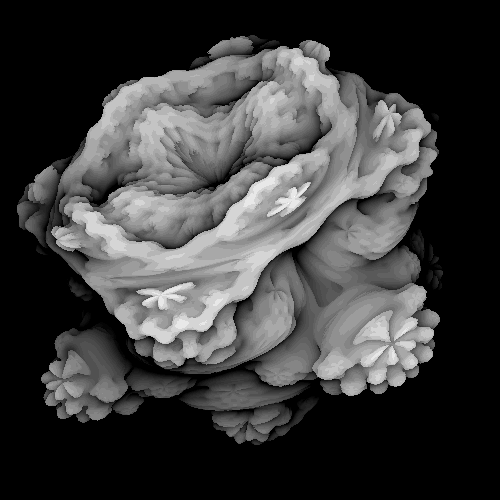

In [27]:
plot_mandelbulb(zoom=0, degree=5, observer_position=observer_position, bailout=2**40, min_distance=5e-3)


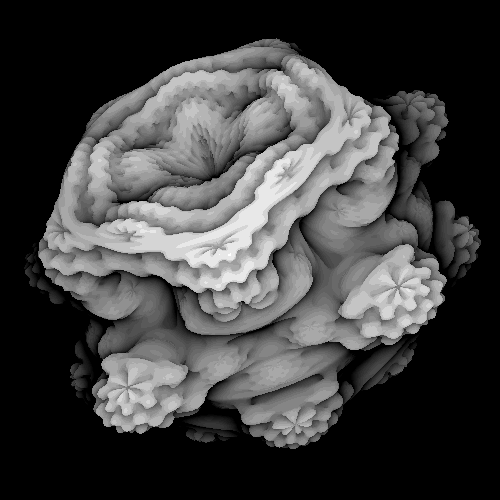

In [28]:
plot_mandelbulb(zoom=0, degree=6, observer_position=observer_position, bailout=2**40, min_distance=5e-3)


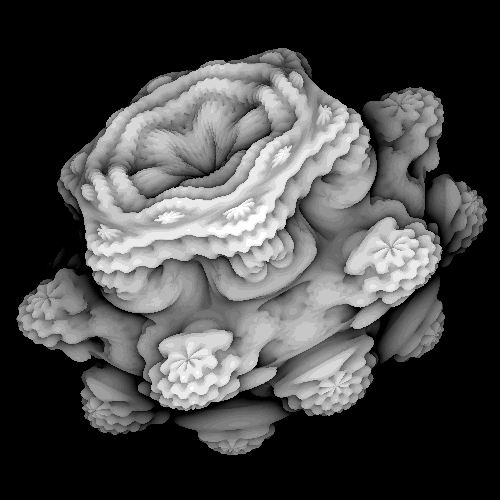

In [29]:
plot_mandelbulb(zoom=0, degree=7, observer_position=observer_position, bailout=2**40, min_distance=5e-3)


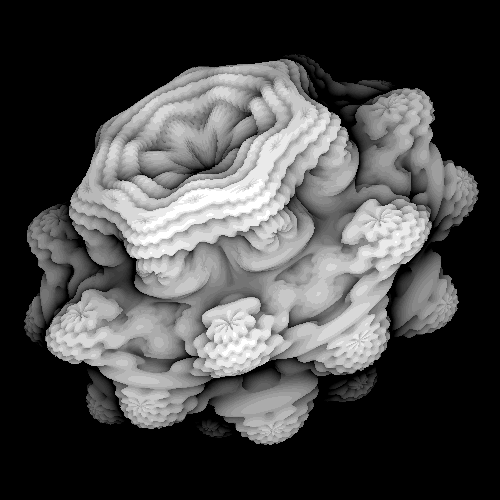

In [30]:
plot_mandelbulb(zoom=0, degree=8, observer_position=observer_position, bailout=2**40, min_distance=5e-3)


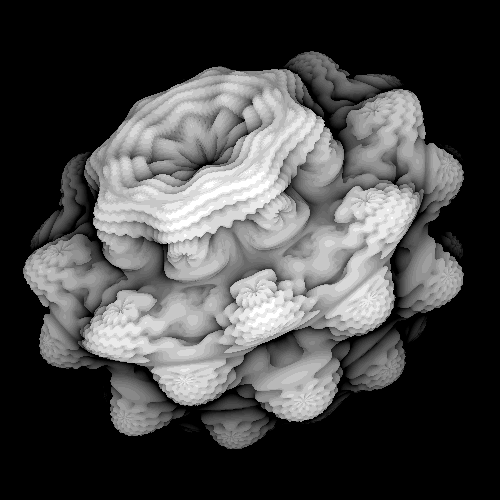

In [31]:
plot_mandelbulb(zoom=0, degree=9, observer_position=observer_position, bailout=2**40, min_distance=5e-3)